# Homework 1

## Solow Model


We consider here, another deterministic version of the neoclassical growth model, but propose a slightly different solution method.

A representative agent uses capital $k_t$ to produce $y_t$ using the following production function:

$$y_t = k_t^{\alpha}$$

He chooses to consume an amount $c_t \in ]0, y_t]$ and invests what remains:

$$i_t = y_t - c_t$$ 

He accumulates capital $k_t$ according to:

$$k_{t+1} = \left( 1-\delta \right) k_{t} + i_{t}$$

where $\delta$ is the depreciation rate and $i_t$ is the amount invested.

The goal of the representative agent is to maximize:

$$\sum_{t\geq 0} \beta^t U(c_t)$$

where $U(x)=\frac{x^{1-\gamma}}{1-\gamma}$ and $\beta<1$ is the discount factor.

For now, we ignore the objective and assume that the saving rate $s=\frac{c_t}{y_t}$ is constant over time.

__Create a structure `Parameters` to hold parameter values $\beta=0.96$, $\delta=0.1$, $\alpha=0.3$, $\gamma=4$__ 

In [87]:
struct Parameters
    β
    δ
    α
    γ
end

parms = Parameters(0.96, 0.1, 0.3, 4.)

Parameters(0.96, 0.1, 0.3, 4.0)

__Write down the formula of function $f$ such that $k_{t+1}$: $k_{t+1} = f(k_t)$.__

We have that $k_{t+1} = (1-\delta)k_t + i_t $. But, $i_t = y_t-c_t = y_t(1-s) = k_t^\alpha (1-s)$. Thus, we deduce that : $ k_{t+1} = (1-\delta)k_t + k_t^\alpha (1-s) $.

__Define a function `f(k::Float64, p::Parameters)::Float64` to represent $f$ for a given calibration__

In [88]:
function f(k::Float64, p::Parameters)
    return (1-p.δ)*k + k^p.α * (1-s)
end

f (generic function with 1 method)

__Write a function `simulate(k0::Float64, T::Int, p::Parameters)::Vector{Float64}` to compute the simulation over `T` periods starting from initial capital level `k0`.__

In [89]:
function simulate(k0::Float64, T::Int, p::Parameters)
    list_of_k = [k0]
    for i in 1:T
        k0 = f(k0,p)
        append!(list_of_k,k0)
    end
    return list_of_k
end

simulate (generic function with 2 methods)

In [90]:
s = 0.1

0.1

__Make a nice plot to illustrate the convergence. Do we get convergence from any initial level of capital?__

In [91]:
using Plots

In [92]:
T = 200
k0 = 2.
s = 0.5
plot([i for i in 0:T], simulate(k0,T, parms), lab = "k0= $k0")

ErrorException: invalid redefinition of constant T

We get the convergence for any $s \in [0.,1.]$ and $k_0$, given the parameters fixed above.

Indeed, $k_{t+1} = 0.9k_t + k_t^0.3(1-s) := f(k_t)$. Thus : $\frac{k_{t+1}}{k_t} = 0.9 + k_t^{-0.7}(1-s) := g(k_t)$.

But : $g'(k) = -0.7(1-s)k^{-1.7} ≤ 0$. And $g(k) = 1 <=> k = (\frac{0.1}{1-s})^0.7 := k_{SS}$. We deduce that if $k_t > k_{SS}$ (resp. $k_t ≤ k_{SS}$) then $k_{t+1} < k_t$ (resp. $k_{t+1} ≥ k_t$). The remaining question is then whether, if $k_t > k_{SS}$ (resp. $k_t ≤ k_{SS}$), we have that $k_{t+1} ≥ k_{SS}$ (resp. $k_{t+1} ≤ k_{SS}$).

We know that $f'(k) = 0.9 + 0.3(1-s)k^{-0.7} ≥ 0 $. It is thus clear that g increases on $[0,+∞]$ and has a fixed point in $k_{SS}$. This validates the previous question and confirms the systematic convergence.

__Suppose you were interested in using `f` to compute the steady-state. What would you propose to measure convergence speed? To speed-up convergence? Implement these ideas.__

It would be interesting to define and follow the evolution of $\eta_t := |k_{t+1} - k_t|$ and use Steffenson's algorithm.

In [93]:
function η(k0::Float64,k1::Float64)
    return abs(k1-k0)
end

function aitken_guess(k0::Float64,k1::Float64,k2::Float64)
    return k0 - (k1-k0)^2 / (k2 - 2*k1 + k0)
end

function speed(k1,k2,k_star)
    return abs(k2-k_star)/abs(k1-k_star)
end

tolerance = 1e-5
T_max = 500

function steffenson(k0::Float64,p::Parameters)
    k1 = f(k0,p)
    k2 = f(k1,p)
    k0 = aitken_guess(k0,k1,k2)
    list_of_speed = [speed(k1, k2, k0)]
    t = 0
    while (t<T_max && η(k2,k0)>tolerance)
        k1 = f(k0,p)
        k2 = f(k1,p)
        k0 = aitken_guess(k0,k1,k2)
        t += 1
        append!(list_of_speed,speed(k1, k2, k0))
    end
    if t==T_max
        return "does not seem to converge"
    end
    return "limit:", k0, "speed:", list_of_speed, "iterations:", t+1
end

ErrorException: cannot define function η; it already has a value

In [94]:
s = 0.5
steffenson(2.,parms) # Very strangely, the speed of convergence seems to be rather linear here (but it might be because I am considering only the first values of the speed whereas it is better to look at the speed for high T).

UndefVarError: UndefVarError: steffenson not defined

__Consider now the full intertemporal objective. Propose a function to approximate it numerically . Plot this objective as a function of the saving rate. Does it depend on the initial capital?__


In [95]:
function u(x::Vector{Float64},p::Parameters)
    return x .^ (1-p.γ) ./ (1-p.γ)
end

function objective(p::Parameters, T::Int, k0::Float64)
    list_of_k = simulate(k0,T,p)
    list_of_c = s*list_of_k .^ p.α
    list_of_u = u(list_of_c,p)
    return sum([p.β^k for k in 0:T] .* list_of_u) + list_of_u[T+1]*p.β^(T+1)/(1-p.β)
end

objective (generic function with 1 method)

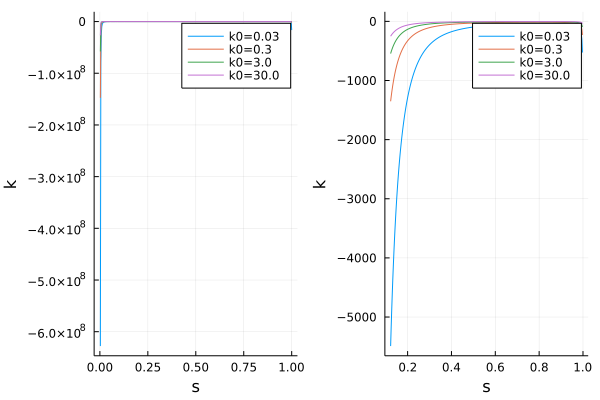

In [96]:
precision = 400 # it's the number of points I make on the graph
k1 = 0.03
k2 = 0.3
k3 = 3.
k4 = 30.
nb_simulations = 200
objectives_k1  = []
objectives_k2 = []
objectives_k3  = []
objectives_k4 = []
list_of_s = []
for i in 0:precision
    s = i/precision
    append!(list_of_s, s)
    append!(objectives_k1, objective(parms, nb_simulations, k1))
    append!(objectives_k2, objective(parms, nb_simulations, k2))
    append!(objectives_k3, objective(parms, nb_simulations, k3))
    append!(objectives_k4, objective(parms, nb_simulations, k4))
end

p1 = plot(list_of_s, objectives_k1, xlabel = "s", ylabel = "k", lab="k0=$k1")
plot!(p1,list_of_s, objectives_k2, lab="k0=$k2")
plot!(p1,list_of_s, objectives_k3, lab="k0=$k3")
plot!(p1,list_of_s, objectives_k4, lab="k0=$k4")

p2 = plot(list_of_s[50:end-1], objectives_k1[50:end-1], xlabel = "s", ylabel = "k", lab="k0=$k1") # it is a zoom on the s not too close from 0 or 1
plot!(p2,list_of_s[50:end-1], objectives_k2[50:end-1], lab="k0=$k2")
plot!(p2,list_of_s[50:end-1], objectives_k3[50:end-1], lab="k0=$k3")
plot!(p2,list_of_s[50:end-1], objectives_k4[50:end-1], lab="k0=$k4")

plot(p1, p2, layout = (1,2))

__Use library Optim.jl to compute optimal saving. Plot it against initial capital. Bonus: compare the optimal steady-state level with the one you can evaluate in closed form.__

In [97]:
using Optim
using LinearAlgebra

In [98]:
function f(s, k::Float64, p::Parameters) # I create another f to set s as an input
    return (1-p.δ)*k + k^p.α * (1-s)
end

function simulate(s, k0::Float64, T::Int, p::Parameters) # I create another simulate to set s as an input
    list_of_k = [k0]
    for i in 1:T
        k0 = f(s, k0, p)
        append!(list_of_k,k0)
    end
    return list_of_k
end

function objective(s::Float64, p::Parameters, T::Int, k0::Float64)
    list_of_k = simulate(s, k0, T, p)
    list_of_c = s*list_of_k .^ p.α
    list_of_u = u(list_of_c,p)
    return sum([p.β^k for k in 0:T] .* list_of_u) + list_of_u[T+1]*p.β^(T+1)/(1-p.β)
end

objective (generic function with 2 methods)

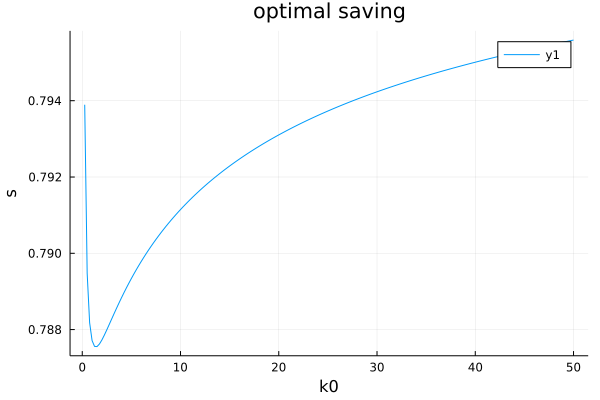

In [121]:
T0 = 300
list_k0 = Float64.([k/4 for k in 1:200])
list_s = [Optim.minimizer(optimize(x -> -objective(x[1], parms, T0, k), [0.], [1.], [0.81]))[1] for k in list_k0]
plot(list_k0,list_s, xlabel ="k0", ylabel = "s", title = "optimal saving")


## Deterministic Neoclassical Model: bruteforce

Model is exactly the same as in the last exercise, but now we look for a time-dependent saving rule, that is a different $s_t$ for each date. We will try to choose $s_t$ to maximize

$$\sum_{t = 0}^T \beta^t U(c_t) + \sum_{t = T+1}^{\infty} \beta^t U(c_T) $$

__Explain why the second term is important__

We have $\sum_{t=T+1}^\infty \beta^t U(c_T) = U(c_T) * \frac{\beta^{T+1}}{1-\beta} << 0 $. Indeed, since $\gamma$ is higher than 1, the utility is always negative and increasing with c. Therefore the second term might be very far from negligible and especially if we don't dare taking a very high T (which requires a high computation time for the first term and is often not worthy because the convergence is fast).

__Choose an horizon $T$ and write a function `objective(s, k0::Float64, T::Int, p::Parameters)` to compute the objective approximated with $T$ periods as a function of initial state `k0::Float64` and of the vector of saving rates `s::Vector` representing $(s_0, s_1, \cdots s_{T})$. Note that argument type of `s` is left unspecified to make it compatible with automatic differentiation.__

In [47]:
function simulate_neoclassical(s, k0::Float64, T::Int, p::Parameters)
    list_of_k = [k0]
    for i in 1:T
        k0 = f(s[i], k0, p)
        append!(list_of_k,k0)
    end
    return list_of_k
end

simulate_neoclassical (generic function with 1 method)

In [48]:
function objective(s, k0::Float64, T::Int, p::Parameters)
    list_of_k = simulate_neoclassical(s, k0, T, p)
    list_of_c = s .* list_of_k .^ p.α
    list_of_u = u(list_of_c,p)
    return sum([p.β^k for k in 0:T] .* list_of_u) + list_of_u[T+1]*p.β^(T+1)/(1-p.β)
end

objective (generic function with 3 methods)

In [53]:
T0=200
objective(rand(T+1),2.,T0,parms)

-152431.42394513558

__Use library `Optim.jl` to maximize the utility function. If possible, find a way to specify derivatives of the objective function.__

In [60]:
k0 = 2.
T0 = 200
res2 = optimize(x -> - objective(x, k0, T0, parms), [0. for k in 1:T0+1], [1. for k in 1:T0+1], rand(T0+1))
Optim.minimizer(res2) # this gives the vector s maximising the utility since I have put a (-) before the objective function.

201-element Vector{Float64}:
 0.7871529909009092
 0.7871893877521557
 0.7872304554822098
 0.7872744860373108
 0.7873201713382715
 0.7873665170296168
 0.7874127733007849
 0.7874583734963454
 0.7875029033870298
 0.7875460638723675
 ⋮
 0.7710448981779895
 0.7690474232618213
 0.7668320138483498
 0.7643782833717073
 0.7616646557429992
 0.7586685608992672
 0.7553665671624806
 0.7517346168261373
 0.9999999999571989

This is counterintuitive : here, people should save nearly all at date T and not before. I would have expected to get nearly the same s all along the path.

## RBC Model with Dolo

__If needed, install Dolo, AxisArrays and DataFrames__

In [109]:
]add DataFrames
]add AxisArrays
]add Dolo

  Resolving package versions...
  Installed PooledArrays ────── v1.2.1
  Installed StructTypes ─────── v1.5.2
  Installed CategoricalArrays ─ v0.9.5
  Installed DataFrames ──────── v0.22.7
  Installed PrettyTables ────── v0.11.1
Updating `~/Teaching/mie37/Project.toml`
  [a93c6f00] + DataFrames v0.22.7
Updating `~/Teaching/mie37/Manifest.toml`
  [324d7699] + CategoricalArrays v0.9.5
  [a8cc5b0e] + Crayons v4.0.4
  [a93c6f00] + DataFrames v0.22.7
  [41ab1584] + InvertedIndices v1.0.0
  [2dfb63ee] + PooledArrays v1.2.1
  [08abe8d2] + PrettyTables v0.11.1
  [856f2bd8] + StructTypes v1.5.2
  [9fa8497b] + Future


__Examine the `yaml` file `rbc.yaml`. It represents a basic version of the RBC model,
similar to the one seen in class.__

In [1]:
filename= "../notebooks/rbc.yaml"

readlines(filename)

63-element Vector{String}:
 "name: Real Business Cycle"
 ""
 "symbols:"
 ""
 "   exogenous: [epsilon]"
 "   states: [z, k]"
 "   controls: [n, i]"
 "   parameters: [beta, sigma, eta, chi, delta, alpha, rho, zbar, sig_z]"
 ""
 "definitions: |"
 ⋮
 ""
 ""
 "exogenous: "
 "    epsilon: !UNormal"
 "        sigma: 0.001"
 ""
 "domain:"
 "    z: [-0.1, 0.1]"
 "    k: [0.5*k, 1.5*k]"

__What are the states (predetermined variables), what are the controls (to be determined), what are the exogenous variables?__

$z_t$ (productivity) and $k_t$ (capital) are the states.

$n_t$ (labour) and $i_t$ (investment) are the controls.

$\epsilon_t$ is the exogeneous shock.

__Compare the calibration from the yaml file, with the one given in the course. What is the specification for the utility function? ($U$ and $V$)__

Here, the calibration mentions that $U(c_t, n_t) = \frac{c_t^{1-\sigma}}{1-\sigma} - \chi \frac{n_t^{1+\eta}}{1+\eta}$ and $V(c_t) = \frac{log(c_t)}{1-\beta}$. 

This is not exactly like in the course since, in the course, it said that the total utility looks like $U(c_t) +\chi V(1-n_t)$ with $U'≥0$, $U"≤0$, $U'(0)=+\infty$ and $U'(+\infty)=0$ (idem for V).

However, $u0(c_t) := \frac{c_t^{1-\sigma}}{1-\sigma} = -\frac{1}{4c_t^4}$ verifies the Inada conditions. $V(c_t)$ too. But, the fact that $\chi = \frac{w}{c^\sigma *n^\eta}$ is what allows to find a closed form solution for the steady state as in the course.

__Import the model. Inspect fields symbols and exogenous.__

In [1]:
using Dolo
model = yaml_import("rbc.yaml")

Model

In [2]:
model.symbols

Dict{Symbol, Vector{Symbol}} with 4 entries:
  :controls   => [:n, :i]
  :states     => [:z, :k]
  :exogenous  => [:epsilon]
  :parameters => [:beta, :sigma, :eta, :chi, :delta, :alpha, :rho, :zbar, :sig_…

`model.exogenous` is a julia object representing the random distribution driving the model

In [3]:
model.exogenous

Dolo.MvNormal([0.0], [1.0e-6])

In [4]:
# one can simulate 2 sets of simulations for 10 periods with
sim = Dolo.simulate(model.exogenous, 2, 10)

3-dimensional AxisArray{Float64,3,...} with axes:
    :V, 1:1
    :N, 1:2
    :T, 1:10
And data, a 1×2×10 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0

[:, :, 2] =
 -0.00167173  0.000253332

[:, :, 3] =
 0.000111536  0.000742954

[:, :, 4] =
 0.000851613  -0.00055654

[:, :, 5] =
 0.000498942  0.00195736

[:, :, 6] =
 0.00017375  -0.00130362

[:, :, 7] =
 0.00116603  -0.00103126

[:, :, 8] =
 0.00139274  0.000305739

[:, :, 9] =
 -0.000526224  0.0018782

[:, :, 10] =
 0.000297456  0.000938546

In [5]:
# the result is a special AxisArray object
# it is essentially a multidmensional array with labels on axes
# which is super useful to avoid reordering mistakes
using AxisArrays
sim[Axis{:V}(1), Axis{:N}(1)] 

1-dimensional AxisArray{Float64,1,...} with axes:
    :T, 1:10
And data, a 10-element Vector{Float64}:
  0.0
 -0.001671725980348356
  0.00011153550163534923
  0.0008516132938763589
  0.0004989418822108454
  0.00017374983465866736
  0.0011660269992798185
  0.0013927430117652308
 -0.000526223740936376
  0.00029745558330743156

In [6]:
# Here is the first simulation as a regular vector
sim[Axis{:V}(1), Axis{:N}(1)].data

10-element Vector{Float64}:
  0.0
 -0.001671725980348356
  0.00011153550163534923
  0.0008516132938763589
  0.0004989418822108454
  0.00017374983465866736
  0.0011660269992798185
  0.0013927430117652308
 -0.000526223740936376
  0.00029745558330743156

__Check that the calibration given in the yaml file satisfies the steady-state__

In [7]:
# calibration, both for the parameters and the steady-state values is a dict-like object:
model.calibration

ModelCalibration(FlatCalibration(:sigma => 5.0, :n => 0.33, :zbar => 0.0, :beta => 0.99, :eta => 1.0, :epsilon => 0.0, :alpha => 0.33, :sig_z => 0.016, :rho => 0.8, :z => 0.0…), GroupedCalibration(:controls => [0.33, 0.23387445725364966], :states => [0.0, 9.354978290145986], :exogenous => [0.0], :parameters => [0.99, 5.0, 1.0, 23.95785990938192, 0.025, 0.33, 0.8, 0.0, 0.016]), Dict(:alpha => (:parameters, 6), :n => (:controls, 1), :rho => (:parameters, 7), :delta => (:parameters, 5), :eta => (:parameters, 3), :epsilon => (:exogenous, 1), :sigma => (:parameters, 2), :k => (:states, 2), :sig_z => (:parameters, 9), :z => (:states, 1)…), OrderedCollections.OrderedDict(:exogenous => [:epsilon], :states => [:z, :k], :controls => [:n, :i], :parameters => [:beta, :sigma, :eta, :chi, :delta, :alpha, :rho, :zbar, :sig_z]))

In [8]:
# which can behave in several ways:
model.calibration.flat

FlatCalibration with 21 entries:
  :sigma   => 5.0
  :n       => 0.33
  :zbar    => 0.0
  :beta    => 0.99
  :eta     => 1.0
  :epsilon => 0.0
  :alpha   => 0.33
  :sig_z   => 0.016
  :rho     => 0.8
  :z       => 0.0
  :delta   => 0.025
  :m       => 0.0
  :rk      => 0.035101
  :k       => 9.35498
  :y       => 0.995058
  :w       => 2.02027
  :i       => 0.233874
  :c       => 0.761184
  :chi     => 23.9579
  ⋮        => ⋮

In [9]:
model.calibration.grouped

GroupedCalibration with 4 entries:
  :controls   => [0.33, 0.233874]
  :states     => [0.0, 9.35498]
  :exogenous  => [0.0]
  :parameters => [0.99, 5.0, 1.0, 23.9579, 0.025, 0.33, 0.8, 0.0, 0.016]

In [10]:
# we get values of parameters and steady_state values
e, s, x, p = model.calibration[:exogenous, :states, :controls, :parameters]

4-element Vector{Vector{Float64}}:
 [0.0]
 [0.0, 9.354978290145986]
 [0.33, 0.23387445725364966]
 [0.99, 5.0, 1.0, 23.95785990938192, 0.025, 0.33, 0.8, 0.0, 0.016]

Denoting the vector of states by $s_t$, the vector of controls by $x_t$ and the vector of exogenous shocks by $e_t$, the *general specification* of a model in Dolo is:

$$
E_t \left[ f(e_t, s_t, x_t, e_{t+1}, s_{t+1}, x_{t+1}) \right]  = 0 \\\\
s_t =  g(e_{t-1}, s_{t-1}, x_{t-1}, e_t)
$$

The are represented in the function  Dolo.arbitrage and Dolo.transition respectively.

In [11]:
Dolo.arbitrage(model,e,s,x,e,s,x,p) # this is all zero

2-element Vector{Float64}:
 -2.3650900419212035e-16
 -5.5421436239368925e-17

In [12]:
Dolo.transition(model, e,s,x,e,p) - s

2-element Vector{Float64}:
 0.0
 0.0

### Perturbation

Since the shock doesn't appear at date $t$ in the arbitrage function or at date $t-1$ in the transition equation, the first order dynamics can be characterized by:

$$
\mathbb{E}_t \left[ f^{\prime}_{s_t} \Delta s_t + f^{\prime}_{x_t} \Delta x_t + f^{\prime}_{e_{t+1}} e_{t+1} + f^{\prime}_{s_{t+1}} \Delta s_{t+1} + f^{\prime}_{x_{t+1}} \Delta x_{t+1} \right]  =  0 \\\\
\Delta s_{t} = g^{\prime}_{s_{t-1}} \Delta s_{t-1} + g^{\prime}_{x_{t-1}} \Delta x_{t-1} + g^{\prime}_{e_t} e_{t}
$$

Taking into account the fact the $e_{t+1}$ is zero mean it simplifies as:

$$
\mathbb{E}_t \left[ \underbrace{ f^{\prime}_{s_t}}_{A} \Delta s_t + \underbrace{f^{\prime}_{x_t}}_{B} \Delta x_t + \underbrace{f^{\prime}_{s_{t+1}}}_{C} \Delta s_{t+1} + \underbrace{ f^{\prime}_{x_{t+1}}}_{D}\Delta x_{t+1} \right] = 0 \\\\
\Delta s_{t}  =  \underbrace{g^{\prime}_{s_{t-1}}}_{E} \Delta s_{t-1} + \underbrace{g^{\prime}_{x_{t-1}}}_{F} \Delta x_{t-1} + \underbrace{g^{\prime}_{e_t}}_{Q} e_{t}
$$

The solution of this system, is a matrix $X$ such that $\Delta x_t = X \Delta s_t$ satisfies the arbitrage equation for any $\Delta s_t$ (once the transition equation is susbtituted in).

__Compute derivatives A,B,C,D,E,F,Q using Dolo. Check that they have the right dimensions.__

In [13]:
A,B,C,D,E,F = Dolo.get_gf_derivatives(model)

([0.19999999999999996 0.0; 0.0 0.975], [0.0 0.0; 0.0 1.0], [11.184727590091404 0.39454502087065413; -6.536255055017392 -0.23056859153032627], [34.95244428718071 -13.270578445035312; -13.270578445035309 6.568716708345973], [0.0 0.0; 6.501505055017393 0.23305737336154916], [0.0 0.0; 13.200025414732279 -6.568716708345973])

In [14]:
Q = Dolo.get_ss_derivatives(model)[1][4] 
# slightly convoluted, admittedly, that is because get_ss returns (g_e, g_s, g_x, g_E), (f_e, f_s, f_x, f_E, F_S, f_X)

2×1 Matrix{Float64}:
 1.0
 0.0

In [15]:
@assert size(A) == (2,2) # 2 arbitrage equations x 2 states today

__Define a structure `PerturbedModel` to hold matrices A,B,C,D,E,F.__

In [16]:
struct PerturbedModel
    A::Matrix{Float64}
    B::Matrix{Float64}
    C::Matrix{Float64}
    D::Matrix{Float64}
    E::Matrix{Float64}
    F::Matrix{Float64}
    Q::Matrix{Float64}
end

pm = PerturbedModel(A,B,C,D,E,F,Q)

PerturbedModel([0.19999999999999996 0.0; 0.0 0.975], [0.0 0.0; 0.0 1.0], [11.184727590091404 0.39454502087065413; -6.536255055017392 -0.23056859153032627], [34.95244428718071 -13.270578445035312; -13.270578445035309 6.568716708345973], [0.0 0.0; 6.501505055017393 0.23305737336154916], [0.0 0.0; 13.200025414732279 -6.568716708345973], [1.0; 0.0])

__We look for a linear solution $x_t = X s_t$ where $X$ is a 2x2 matrix. Write the matrix equation which `X` must satisfy. Write a function `residual(X::Array, M::PerturbedModel)` which to the residual of this equation for a given `X`.__


$A+BX+(C+DX)(E+FX) = 0$

In [17]:
function residual(X::Array, M::PerturbedModel)
    return M.A + M.B*X + (M.C + M.D*X)*(M.E +M.F*X)
end

residual (generic function with 1 method)

__Write a function `T(X, M::PerturbedModel)`  which implements the time iteration step.__

In [18]:
function T(X, M::PerturbedModel)
    return -(M.B + (M.C + M.D*X) * M.F)\(M.A + (M.C + M.D*X)* M.E)
end

T (generic function with 1 method)

__Write function `linear_time_iteration(X_0::Matrix, m::PerturbedModel)::Matrix` which implements the time iteration algorithm. Apply it to `X0 = rand(1,2)` and check that the result satisfies the first order model.__

    

In [19]:
ϵ0 = 1.e-5
η0 = 1.e-5
max_it = 2000
function linear_time_iteration(X_0::Matrix, M::PerturbedModel)
    X_1 =  T(X_0, M)
    iterations = 1
    while iterations < max_it && (sum(abs.(X_1-X_0)) > η0 || sum(abs.(residual(X_1,M))) > ϵ0)
        X_0 = X_1
        X_1 =  T(X_0, M)
        iterations += 1
    end
    return X_1
end

linear_time_iteration (generic function with 1 method)

In [20]:
X0 = rand(2,2)
sol_time_iteration = linear_time_iteration(X0, pm)

2×2 Matrix{Float64}:
 -0.489856    -0.502844
 -0.00178989  -0.975

__Define two linear operators `L_S(S::Matrix, X_0::Matrix, m::PerturbedModel)::Matrix` and `L_T(S::Matrix, X_0::Matrix, m::PerturbedModel)::Matrix` which implement the derivatives of the simulation and the time-iteration operator respectively.__

In [55]:
function L_S(S::Matrix, X_0::Matrix, m::PerturbedModel) # I am not sure to understand what should be S and why it is a MAtrix and not a vector
    return (m.E + m.F*linear_time_iteration(X_0,m)) * S 
end

function L_T(S::Matrix, X_0::Matrix, m::PerturbedModel)
    X_SS = linear_time_iteration(X_0,m)
    return (m.B + (m.C +m.D*X_SS) * m.F) \ m.D * S * (m.E + m.F * X_SS)
end

L_T (generic function with 2 methods)

__Implement a function `spectral_radius(f::Function)::Float64` which implements the power iteration method to compute the biggest eigenvalues of the two previously defined operators. Check that Blamnchard-Kahn conditions are met.__

In [82]:
function norm(x::Matrix{Float64})
    return maximum(abs.(eigvals(x)))
end

function norm(x::Vector{Float64})
    return sqrt(sum(x.^2))
end

norm (generic function with 2 methods)

In [83]:
η = 1.e-5

function spectral_radius(f::Function)
    x0 = rand(2)
    u0 = x0 ./ norm(x0)
    x1 = f(u0, X0, pm)
    u1 = x1 ./ norm(x1)
    while norm(u1-u0) > η
        u0 = u1
        x1 = f(u0, X0, pm)
        u1 = x1 ./ norm(x1)
    end
    return norm(x1)
end

function spectral_radius2(f::Function)
    x0 = rand(2,2)
    u0 = x0 ./ norm(x0)
    x1 = f(u0, X0, pm)
    u1 = x1 ./ norm(x1)
    while norm(u1-u0) > η
        u0 = u1
        x1 = f(u0, X0, pm)
        u1 = x1 ./ norm(x1)
    end
    return norm(x1)
end

spectral_radius2 (generic function with 1 method)

In [84]:
spectral_radius(L_S)

7.494005416219807e-16

In [85]:
# Checking the result for the simulation operator => OK
maximum(abs.(eigvals(pm.E + pm.F*linear_time_iteration(X0,pm))))

7.494005416219807e-16

In [ ]:
spectral_radius2(L_T) # do not know if it works. It's far too long.

__Compare the solution with the one obtained by dolo__

In [23]:
sol_dolo = Dolo.perturb(model)

Perturbation Results
 * Decision Rule type: Dolo.BiTaylorExpansion{2}
 * stable < true
 * determined < true


In [24]:
X_dolo = sol_dolo.dr.x_s

2×2 Matrix{Float64}:
 0.207879  -0.0152809
 1.39034   -0.0105166

__Compute the transition matrix $P = E + F X$__

In [25]:
P = pm.E + pm.F*X_dolo

2×2 Matrix{Float64}:
 0.0       0.0
 0.112768  0.100429

__Create a structure to hold the solution__

In [26]:
struct Solution
    X::Matrix{Float64}
    P::Matrix{Float64}  # transition matrix
    Q::Matrix{Float64}
    shock               # set it to model.exogenous
end

In [27]:
sol = Solution(X_dolo, P, pm.Q, model.exogenous)

Solution([0.20787915142620136 -0.015280943914675495; 1.390339699599508 -0.010516596585492944], [0.0 0.0; 0.11276752200022067 0.10042906903279578], [1.0; 0.0], Dolo.MvNormal([0.0], [1.0e-6]))

__Write a function `simulate(s0::Vector, sol::Solution, T::Int64)::Tuple{Matrix, Matrix}` to simulate the model over $T$ periods (by using the formula $\Delta s_t = P s_{t-1} + Q e_t$. Return a matrix for the states (one line per date) and another matrix for the controls. Use Dolo.simulation(sol.shock) to simulate the exogenous shock.__

__Bonus: add a keyword option to compute variables levels or log-deviations. If possible, return a DataFrame or an AxisArrays object.__

In [33]:
using LinearAlgebra
function simulate(s0::Vector, sol::Solution, T::Int64; result_in_level=false)
    simulated_states = zeros(T,2)
    simulated_controls = zeros(T,2)
    e = Dolo.simulate(sol.shock,1,T-1)
    simulated_states[1,:] = s0
    simulated_controls[1,:] = sol.X*s0
    for i in 1:T-1
        s = (sol.P + Matrix(I,2,2)) * s0 + sol.Q * e[i]
        simulated_states[i+1,:] = s
        simulated_controls[i+1,:] = sol.X*s
    end
    if result_in_level == true
        return log.(simulated_states), log.(simulated_controls)
    end
    return simulated_states, simulated_controls
end

simulate (generic function with 1 method)

In [34]:
simulate([0.3,0.4],sol, 100)[1]
simulate([0.3,0.4],sol, 100)[2]

100×2 Matrix{Float64}:
 0.0562514  0.412895
 0.0551205  0.412117
 0.0548347  0.410206
 0.0550971  0.41196
 0.0550729  0.411798
 0.0550758  0.411818
 0.0551247  0.412145
 0.0552571  0.41303
 0.0552486  0.412974
 0.054767   0.409752
 ⋮          
 0.0549826  0.411194
 0.0550484  0.411634
 0.055107   0.412026
 0.0549964  0.411287
 0.0548969  0.410621
 0.0551085  0.412037
 0.0549054  0.410678
 0.0553048  0.413349
 0.0553134  0.413407

__Write a function response(sol::Solution, T::Int64, δ::Float64) which computes the deterministic response of a model, followint an initial deviation of the shock δ.__

As I understand it, we want to compare the initial exogeneous shock with another exogeneous shock deviated initially (ie for t=1) and not after. To show the response to that, I think that the initial state is required to compute the entire time path of the states.

In [30]:
function response(s0::Vector, sol::Solution, T::Int64, δ::Float64)
    simulated_states = zeros(T,2)
    simulated_controls = zeros(T,2)
    e = Dolo.simulate(sol.shock,1,T-1)
    e[1] += δ
    simulated_states[1,:] = s0
    simulated_controls[1,:] = sol.X*s0
    for i in 1:T-1
        s = (sol.P + Matrix(I,2,2)) * s0 + sol.Q * e[i]
        simulated_states[i+1,:] = s
        simulated_controls[i+1,:] = sol.X*s
    end
    return simulated_states, simulated_controls
end

response (generic function with 1 method)

In [35]:
response([0.3,0.4],sol, 100, 3.)[1] # states
response([0.3,0.4],sol, 100, 3.)[2] # controls

100×2 Matrix{Float64}:
 0.0562514  0.412895
 0.678758   4.58314
 0.0553239  0.413477
 0.0553106  0.413388
 0.0548756  0.410478
 0.0555315  0.414865
 0.0547784  0.409829
 0.0550466  0.411622
 0.0547915  0.409917
 0.055271   0.413123
 ⋮          
 0.0547686  0.409763
 0.0551428  0.412266
 0.0551741  0.412475
 0.0549723  0.411126
 0.0553426  0.413602
 0.0551412  0.412255
 0.0548391  0.410234
 0.0551119  0.412059
 0.0550688  0.411771

__Bonus: Introduce a 10% income tax in the model, by editing the yaml file. How does it affect the responses of the model's variables?__